#Milestone 4#

Group Members: Udayan Bulchandani, Juan Pablo Heusser, Curren Iyer.

Group: 13

# Problem Statement Refinement #

After researching BERT and VisualBERT more extensively, we realized that the model is not capable (nor is it built with this goal) to generate text. And so we changed our problem statement to fine-tune a pretrained VisualBert model for multiple choice question answering, where the model is fed with ([question, image], answer choice) pairs, and the model returns the probability for each choice to be the correct one.

In terms of significance, it certainly impacts our goal of helping K-12 students learn science, but it can still become a great study tool to help students work through practice problem sets.


# Comprehensive EDA Review#

##Dataset Description##

We will be using the ScienceQA dataset which is accesible via Hugging Face via the following link:

https://huggingface.co/datasets/derek-thomas/ScienceQA

The dataset contains 21,208 questions multimodal multiple-choice science questions of elementary and high school level. The following metrics are available in the dataset's description, which we will check in this notebook:

 - Questions with image context: 48.7%
 - Questions with text context: 48.2%
 - Questions with both image and text context: 30.8%

 The dataset is split into training and test datasets. The training dataset has 12,726 data points (60%) and the test dataset has 4,241 datapoints (40%).

 The dataset has the following variables (columns):

  - image: The contextual image to answer the question

    - dictionary('bytes': byte)

  - question: Question prompt

    - string

  - choices: Multiple choice answers with, where only 1 option is correct

    - list(string, ...)

  - answer: Index of the choice corresponding to the correct answer

    - integer - one of [0,1,2,3,4]

  - hint: A helpful hint to answer the question

    - string

  - task: A description of the task that the student needs to solve

    - string - one of ['closed choice', 'yes or no', 'true-or false']

  - grade: Grade level from K to 12

    - string - one of ['grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6',
       'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12']

  - subject: The school subject to which the question belongs

    - string - one of ['social science', 'natural science', 'language science']

  - topic: a subcategory of subject

    - string - one of ['geography', 'science-and-engineering-practices', 'verbs',
       'chemistry', 'writing-strategies', 'biology', 'physics',
       'units-and-measurement', 'figurative-language', 'economics',
       'reference-skills', 'phonological-awareness', 'grammar',
       'earth-science', 'punctuation', 'capitalization', 'us-history',
       'reading-comprehension', 'world-history', 'civics', 'vocabulary',
       'literacy-in-science', 'word-study', 'culture', 'pronouns',
       'global-studies']

  - category: A subcategory of topic

    - string

  - skill: The skill being tested by the question

    - string

  - lecture: Lecture summary from where the question was pulled

    - string

  - solution: Text explanation of the solution to the question

    - string


###Initial Imports and Data Loading###

In [1]:
# Install datasets package
%%capture
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install --upgrade huggingface_hub
!pip install torchview

In [2]:
# Imports
from collections import Counter
from datasets import load_dataset
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

In [3]:
# Load dataset
dataset = load_dataset('derek-thomas/ScienceQA')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [4]:
# Separate train and test data
train_data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()

print(f'Shape of train data: {train_data.shape}')
print(f'Shape of test data: {test_data.shape}')

Shape of train data: (12726, 13)
Shape of test data: (4241, 13)


In [5]:
# Inspect data
train_data.head()

,image,question,choices,answer,hint,task,grade,subject,topic,category,skill,lecture,solution
0,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Which of these states is farthest north?,"[West Virginia, Louisiana, Arizona, Oklahoma]",0,,closed choice,grade2,social science,geography,Geography,Read a map: cardinal directions,"Maps have four cardinal directions, or main di...","To find the answer, look at the compass rose. ..."
1,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Identify the question that Tom and Justin's ex...,[Do ping pong balls stop rolling along the gro...,1,The passage below describes an experiment. Rea...,closed choice,grade8,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,
2,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,Identify the question that Kathleen and Bryant...,[Does Kathleen's snowboard slide down a hill i...,0,The passage below describes an experiment. Rea...,closed choice,grade7,natural science,science-and-engineering-practices,Designing experiments,Identify the experimental question,Experiments can be designed to answer specific...,
3,None,Which tense does the sentence use?\nMona will ...,"[present tense, future tense, past tense]",1,,closed choice,grade2,language science,verbs,Verb tense,"Is the sentence in the past, present, or futur...",Present tense verbs tell you about something t...,The sentence is in future tense. You can tell ...
4,None,Complete the sentence.\nSewing an apron is a ().,"[chemical change, physical change]",1,,closed choice,grade4,natural science,chemistry,Physical and chemical change,Identify physical and chemical changes,Chemical changes and physical changes are two ...,Sewing an apron is a physical change. The fabr...


### Visualizing an Example Image###


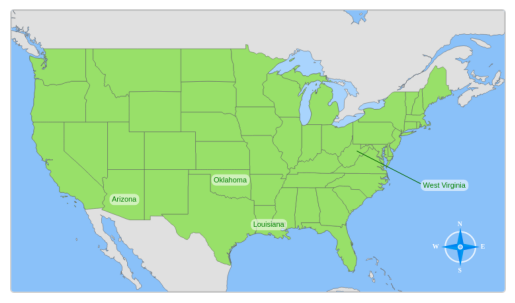

In [6]:
# Visualize a single image
image_bytes = train_data.loc[0, 'image']['bytes']
image = Image.open(BytesIO(image_bytes))

plt.imshow(image)
plt.axis('off')
plt.show()

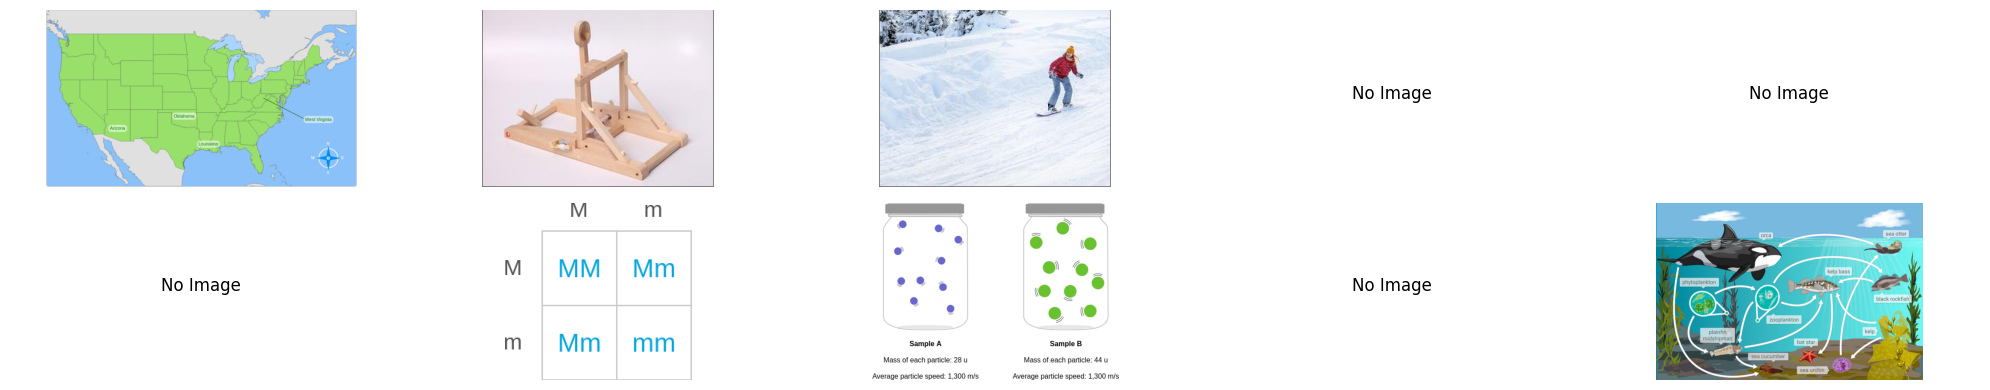

In [7]:
# Visualize images of ten first rows
fig, axes = plt.subplots(2, 5, figsize=(20, 4))
axes = axes.flatten()

for i, (index, row) in enumerate(train_data.head(10).iterrows()):
    image_bytes = row['image']
    if image_bytes is not None:
        image = Image.open(BytesIO(image_bytes['bytes']))
        axes[i].imshow(image)
    else:
        axes[i].text(0.5, 0.5, 'No Image', fontsize=12, ha='center')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Finding Missing Values

From a first glance, it seems that only image values are missing for almost 49% of the datapoints.

In [8]:
# Inspect train data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12726 entries, 0 to 12725
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6218 non-null   object
 1   question  12726 non-null  object
 2   choices   12726 non-null  object
 3   answer    12726 non-null  int8  
 4   hint      12726 non-null  object
 5   task      12726 non-null  object
 6   grade     12726 non-null  object
 7   subject   12726 non-null  object
 8   topic     12726 non-null  object
 9   category  12726 non-null  object
 10  skill     12726 non-null  object
 11  lecture   12726 non-null  object
 12  solution  12726 non-null  object
dtypes: int8(1), object(12)
memory usage: 1.2+ MB


But on deeper exploration, there are empty string values some of the columns.

```
x = ''
```

So we replaced each empty string value for None, so that they are easy to identify.



In [9]:
# Replace empty string values for None
columns_to_check = ['question', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution']

train_data[columns_to_check] = train_data[columns_to_check].applymap(lambda x: None if x == '' else x)
test_data[columns_to_check] = test_data[columns_to_check].applymap(lambda x: None if x == '' else x)



In [10]:
# Inspect train data with replaced values
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12726 entries, 0 to 12725
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     6218 non-null   object
 1   question  12726 non-null  object
 2   choices   12726 non-null  object
 3   answer    12726 non-null  int64 
 4   hint      6079 non-null   object
 5   task      12726 non-null  object
 6   grade     12726 non-null  object
 7   subject   12726 non-null  object
 8   topic     12726 non-null  object
 9   category  12726 non-null  object
 10  skill     12726 non-null  object
 11  lecture   10692 non-null  object
 12  solution  11515 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.3+ MB


In [11]:
# Inspect test data with replaced values
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4241 entries, 0 to 4240
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     2017 non-null   object
 1   question  4241 non-null   object
 2   choices   4241 non-null   object
 3   answer    4241 non-null   int64 
 4   hint      2046 non-null   object
 5   task      4241 non-null   object
 6   grade     4241 non-null   object
 7   subject   4241 non-null   object
 8   topic     4241 non-null   object
 9   category  4241 non-null   object
 10  skill     4241 non-null   object
 11  lecture   3532 non-null   object
 12  solution  3839 non-null   object
dtypes: int64(1), object(12)
memory usage: 430.9+ KB


### Data Imbalance

We now consider the level of imbalance in our dataset. We examine only the following categorical variables: grade, subject, topic and category. Histograms for each are shown below.

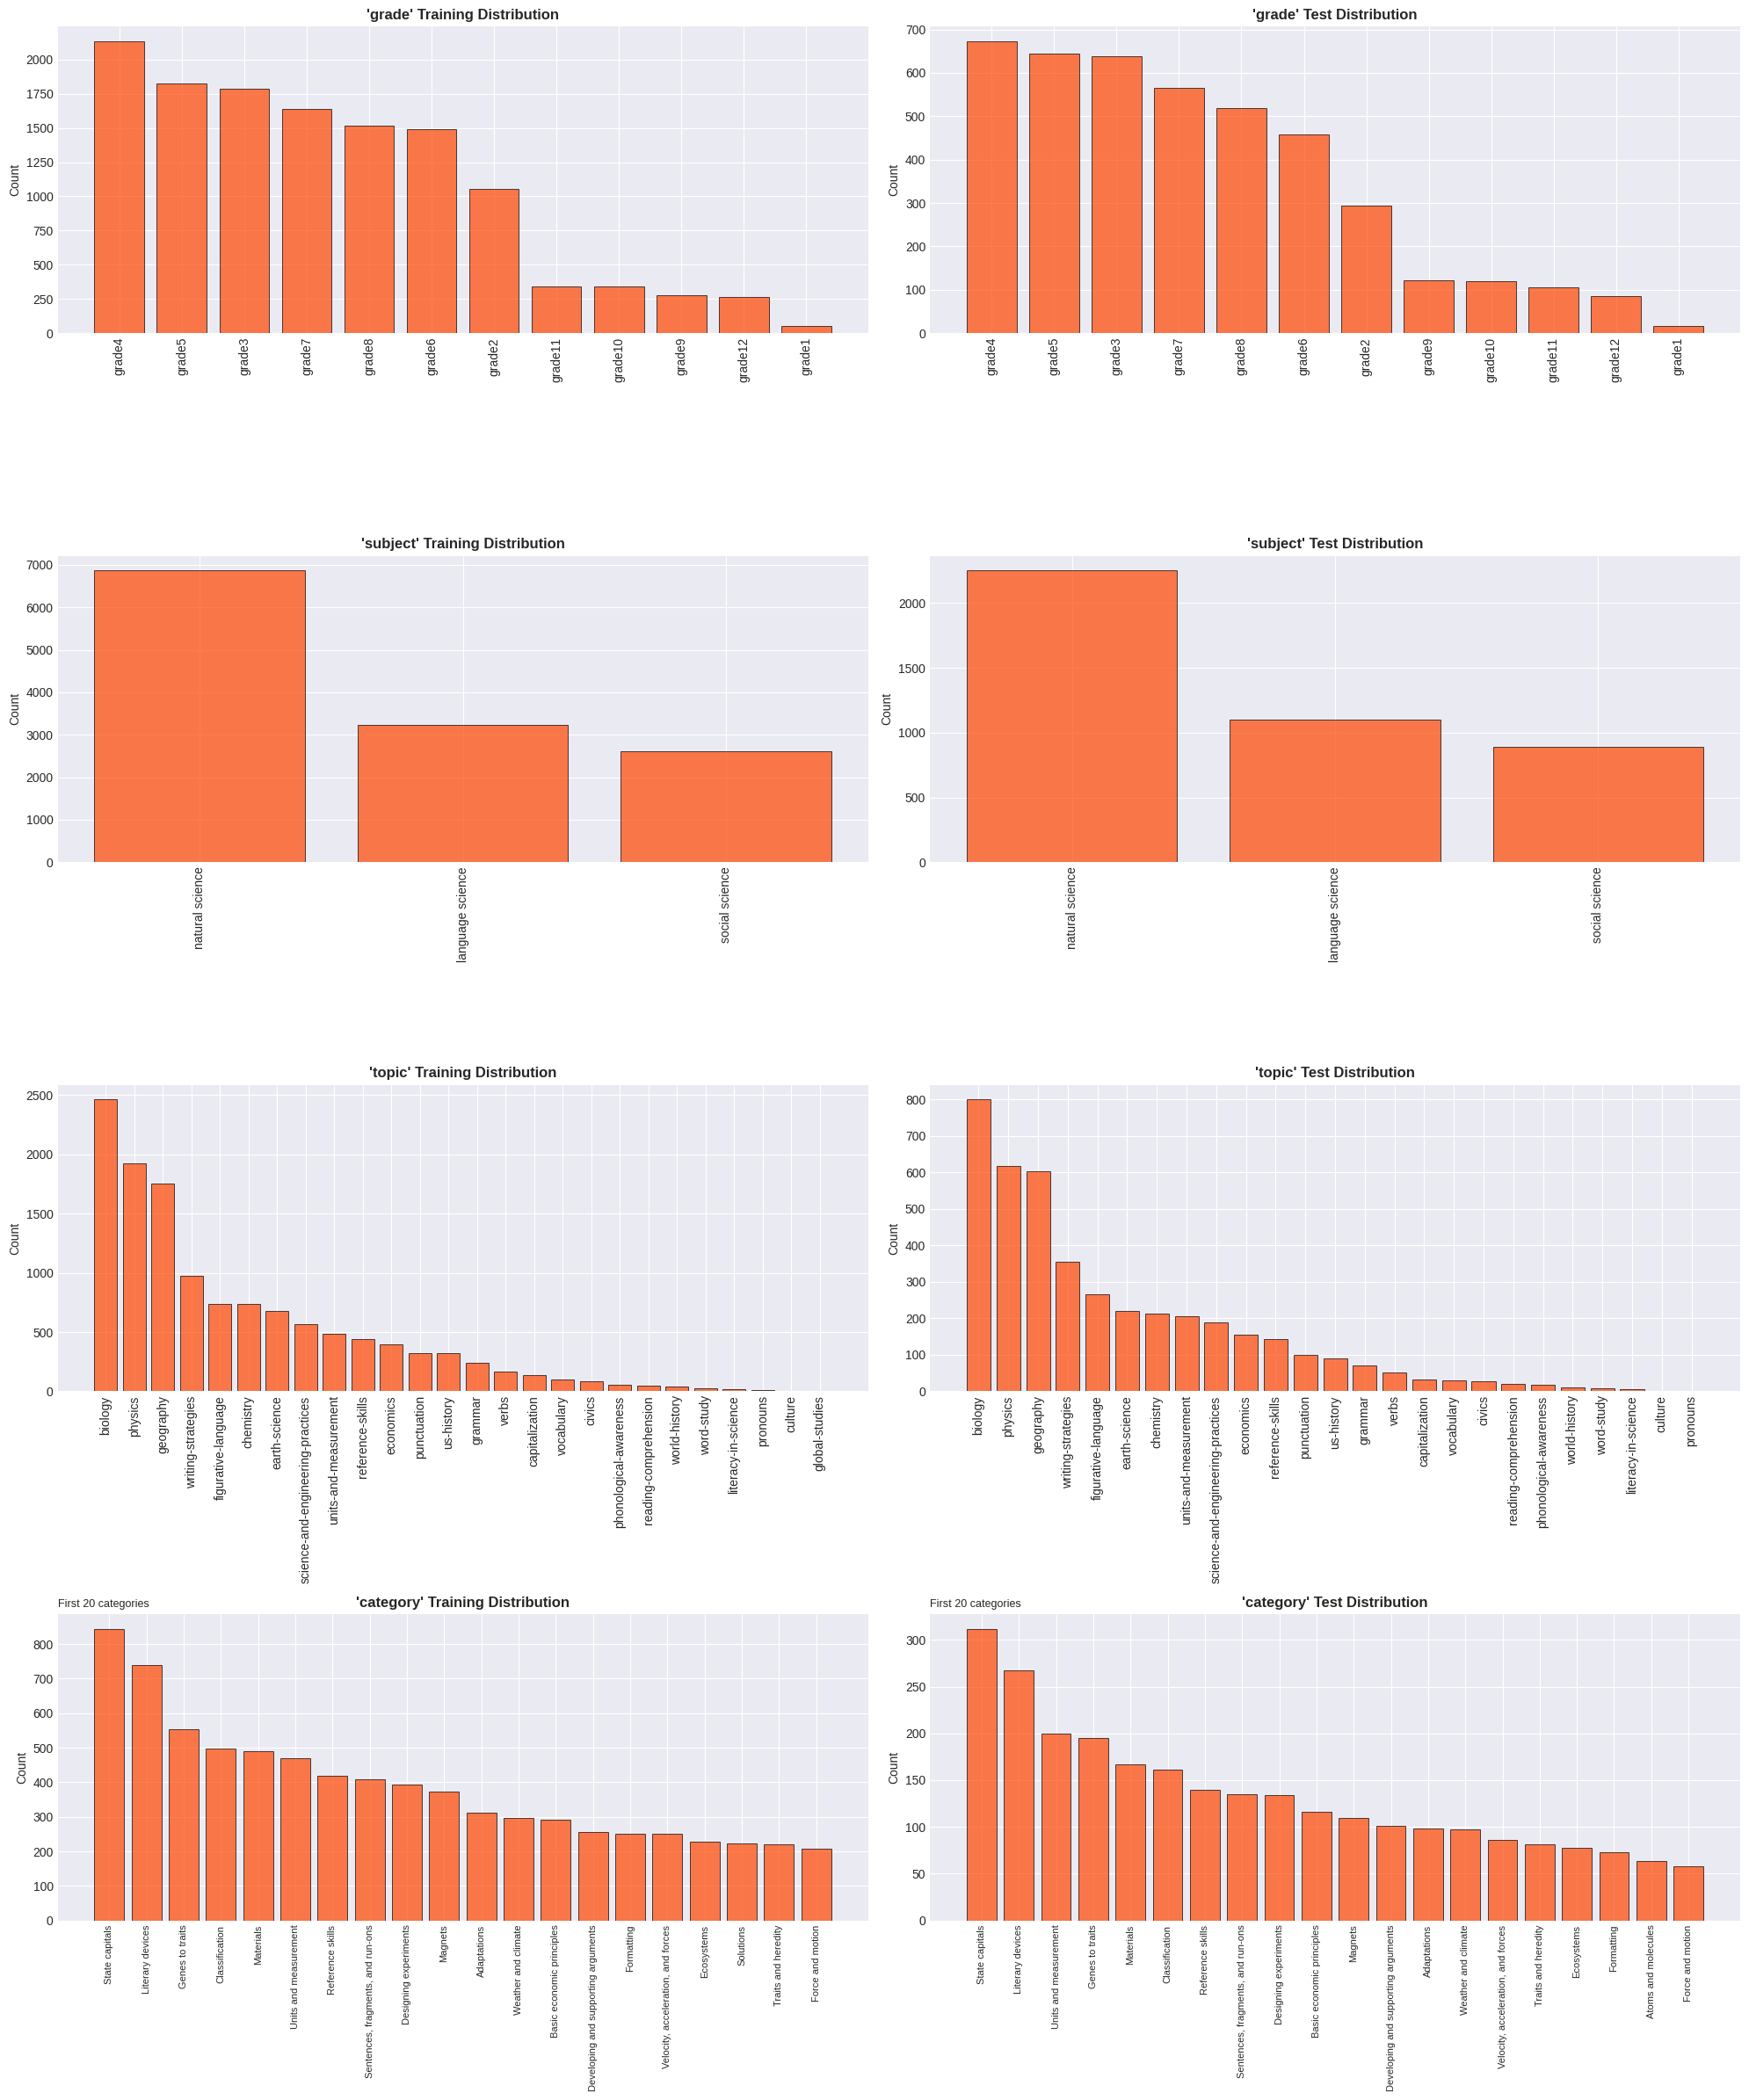

In [12]:
def plot_histogram(values, axis, small_fonts):
    counts = Counter(values)
    common = counts.most_common()
    labels = [item[0] for item in common]
    number = [item[1] for item in common]
    nbars = len(common)
    if small_fonts:
        axis.bar(np.arange(nbars)[:20], number[:20], tick_label=labels[:20], edgecolor='black', linewidth=.7, color='orangered', alpha=0.7)
        axis.set_title('First 20 categories', loc='left', fontsize=9)
        axis.set_xticklabels(labels[:20], rotation=90, fontsize = 8)
    else:
        axis.bar(np.arange(nbars), number, tick_label=labels, edgecolor='black', linewidth=.7, color='orangered', alpha=0.7)
        axis.set_xticklabels(labels, rotation=90)

columns_to_check = ['grade', 'subject', 'topic', 'category']
plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(4, 2, figsize=(20, 24))
axes = axes.flatten()


for i, column_name in enumerate(columns_to_check):
    train_column = train_data[column_name].values
    train_axis = axes[i*2]
    plot_histogram(train_column, train_axis, column_name == 'category')
    train_axis.set_title(f'\'{column_name}\' Training Distribution', fontweight='bold')
    train_axis.set_ylabel('Count')

    test_column = test_data[column_name].values
    test_axis = axes[i*2+1]
    plot_histogram(test_column, test_axis, column_name == 'category')
    test_axis.set_title(f'\'{column_name}\' Test Distribution', fontweight='bold')
    test_axis.set_ylabel('Count')



plt.tight_layout()
plt.show()

With the exception of subject, these are all somewhat concerning. For topic, grade, and particularly category, each distribution has significant tails - meaning there are many feature values captured by as few as one data point.

For grade, this is likely not a problem, as the grade feature is unlikely to important. Simply bucketing the underrepresented grade ('grade1') into an adjacent category ('grade2') could help.

Topic is more challenging. Perhaps a separate classifier could be built to generate topic labels for each datapoint, which seems like a tractable problem. However, as with grade, the topic feature is unlikely to be relevant.

Finally, category. This is the most challenging to address - it has the most pronounced tail, and there is no clear way to synthesize or group data. However, once again, this feature is unlikely to be relevant to our learned model.

## Constructing Features

### Preprocessing for Multiple Choice

Each row in the ScienceQA dataset has a 'question' field, which contains question text, and a 'choices' field, which contains a variable length list of multiple choice answers.

Bert models handle multiple choice questions by taking in a tokenized pair of sentences, divided the by '[SEP]' token, and generate a binary prediction of whether the second follows the first.

So, we have to convert our multiple choice dataset to sentence pairs. We will end up with one question/answer pair for each multiple choice answer in the original ScienceQA dataset.

Note that questions in the ScienceQA dataset have varying number of multiple choice answers. For batch processing, we need a consistent number of answers for each question, so we pad our dataset with empty answers.

In [13]:
MAX_CHOICES = 5

def preprocess_function(data):

    # Tokenize question/answer pairs

    first_sentences = []
    second_sentences = []
    tokens = {}

    questions = [ [question] * MAX_CHOICES for question in data['question'] ]
    answers = [ list(choices) + ['']*(MAX_CHOICES-len(choices)) for choices in data["choices"] ]

    # The previous lines return lists of lists, so flatten them
    questions = sum(questions, [])
    answers = sum(answers, [])

    tokenized_examples = tokenizer(questions, answers, truncation=True)

    # Generate visual embeddings

    # Get indicies of null and non-null images
    # get a list of images (this may need its own batching hm..)
    # pass them to the pipeline
    # repopulate the '

    # unflatten the reuslts
    return {k: [v[i : i + MAX_CHOICES] for i in range(0, len(v), MAX_CHOICES)] for k, v in tokenized_examples.items()}

In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenized_dataset = dataset['train'].take(5).map(preprocess_function, batched = True)
print(tokenized_dataset[4]['question'])
print(tokenized_dataset[4]['choices'])
print(tokenized_dataset[4]['hint'])
for candidate in tokenized_dataset[4]['input_ids']:
  print(tokenizer.decode(candidate))

## Hugginface models expect the label column name
#tokenized_dataset = tokenized_dataset.rename_column("answer", "label")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5 [00:00<?, ? examples/s]

Complete the sentence.
Sewing an apron is a ().
['chemical change', 'physical change']

[CLS] complete the sentence. sewing an apron is a ( ). [SEP] chemical change [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] physical change [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]
[CLS] complete the sentence. sewing an apron is a ( ). [SEP] [SEP]


In [15]:
from transformers import AutoTokenizer
tokenized_dataset = dataset.map(preprocess_function, batched = True)

## Hugginface models expect the label column name
tokenized_dataset = tokenized_dataset.rename_column("answer", "label")

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

# Visual Embeddings

To be able to process images as inputs, the model needs to use a vision model. Based on the Huggingface documentation for VisualBert, we will use the Detectron2 library. From this library we will use the MaskRCNN ResNet-101 FPN model which has been pre-trained on the COCO (Common Objects in Context) dataset.


In [16]:
import torch
torch.__version__
cuda = torch.cuda.is_available()

In [17]:
%%capture
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

In [18]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [19]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

We need to load the model configuration and weights

In [20]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path, cuda=True):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    if not cuda:
      cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path, cuda)

Based on the loaded weights and configuration we can build the model

In [21]:
def get_model(cfg):
    model = build_model(cfg)

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    model.eval()
    return model

model = get_model(cfg)

model_final_a3ec72.pkl: 254MB [00:02, 123MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


Image preprocessing

In [23]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images, model.backbone.size_divisibility)

    return images, batched_inputs

image_bytes1 = train_data.loc[0, 'image']['bytes']
image1 = np.array(Image.open(BytesIO(image_bytes1)))
#image_bytes2 = train_data.loc[1, 'image']['bytes']
#image2 = np.array(Image.open(BytesIO(image_bytes2)))
#image_bytes3 = train_data.loc[2, 'image']['bytes']
#image3 = np.array(Image.open(BytesIO(image_bytes3)))

images, batched_inputs = prepare_image_inputs(cfg, [image1])

Extract and visualize example features from image using ResNet and Feature Proposal Network

In [24]:
def get_features(model, images):
    images.tensor = images.tensor.to(model.device)
    features = model.backbone(images.tensor)
    return features

features = get_features(model, images)

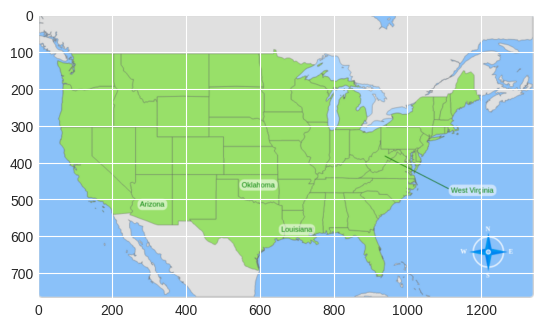

torch.Size([1, 256, 192, 336])


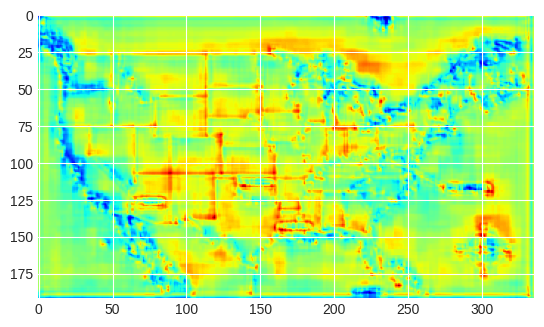

torch.Size([1, 256, 96, 168])


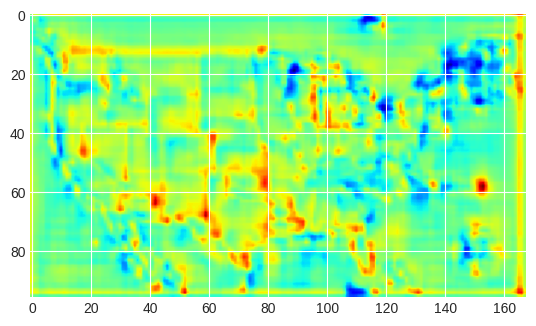

torch.Size([1, 256, 48, 84])


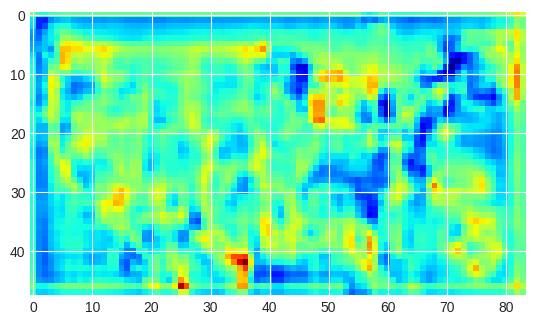

torch.Size([1, 256, 24, 42])


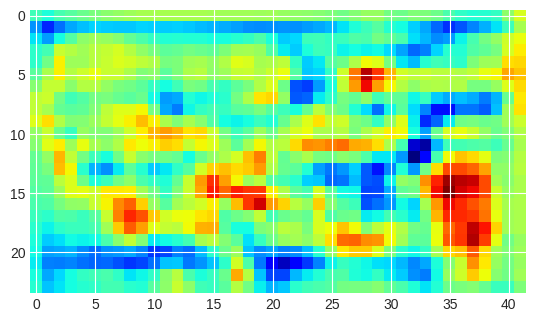

torch.Size([1, 256, 12, 21])


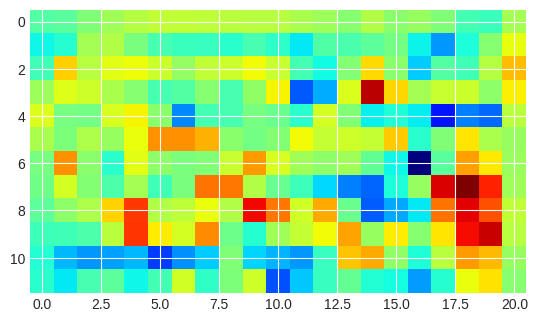

In [25]:
plt.imshow(cv2.resize(image1, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][0,0,:,:].squeeze().cpu().detach().numpy(), cmap='jet')
    plt.show()

The Region Proposal Network (RPN) generates the proposals base on input features and images

In [26]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(model, images, features)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [29]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(2, 1000, 512)
    return box_features, features_list

box_features, features_list = get_box_features(model, features, proposals)

In [30]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

In [31]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

In [32]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

In [33]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1].cpu()
        det_boxes = cls_boxes[:,cls_ind,:].cpu()
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [34]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

In [35]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

In [36]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [39]:
print(len(visual_embeds))
print(visual_embeds[0].shape)

1
torch.Size([100, 512])


# Inference Example

In [40]:
from transformers import VisualBertForMultipleChoice

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
vqa_model = VisualBertForMultipleChoice.from_pretrained("uclanlp/visualbert-vcr")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/441M [00:00<?, ?B/s]

In [41]:
question = train_data.loc[0, 'question']
choices = train_data.loc[0, 'choices']
choice_a = choices[0]
choice_b = choices[1]
choice_c = choices[2] # correct answer
choice_d = choices[3]

In [42]:
print('Question: \n')
print(question)

Question: 

Which of these states is farthest north?


In [43]:
print('Answer Choices: \n')
print(choice_a)
print(choice_b)
print(choice_c)
print(choice_d)

Answer Choices: 

West Virginia
Louisiana
Arizona
Oklahoma


In [46]:
# visual_embeds = torch.stack(visual_embeds)
visual_embeds = visual_embeds.reshape(100, 512)

In [48]:
print(visual_embeds.shape)


torch.Size([100, 512])


In [49]:
questions = [question]*4
choices = [choice_a, choice_b, choice_c, choice_d]

encoding = tokenizer([(q, c) for q, c in zip(questions, choices)], return_tensors="pt", padding=True)

visual_embeds = visual_embeds.expand(1, 4, *visual_embeds.shape)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
labels = torch.tensor(2).unsqueeze(0)

inputs_dict = {k: v.unsqueeze(0).cuda() for k, v in encoding.items()}
inputs_dict.update(
    {
        "visual_embeds": visual_embeds[0].cuda(),
        "visual_attention_mask": visual_attention_mask.cuda(),
        "visual_token_type_ids": visual_token_type_ids.cuda(),
        "labels": labels.cuda(),
    }
)

vqa_model.cuda()



VisualBertForMultipleChoice(
  (visual_bert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=512, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
     

In [50]:
outputs = vqa_model(**inputs_dict)

loss = outputs.loss
logits = outputs.logits



In [51]:
print(logits)

tensor([[1.1943, 1.2253, 1.4653, 1.4727]], device='cuda:0',
       grad_fn=<ViewBackward0>)


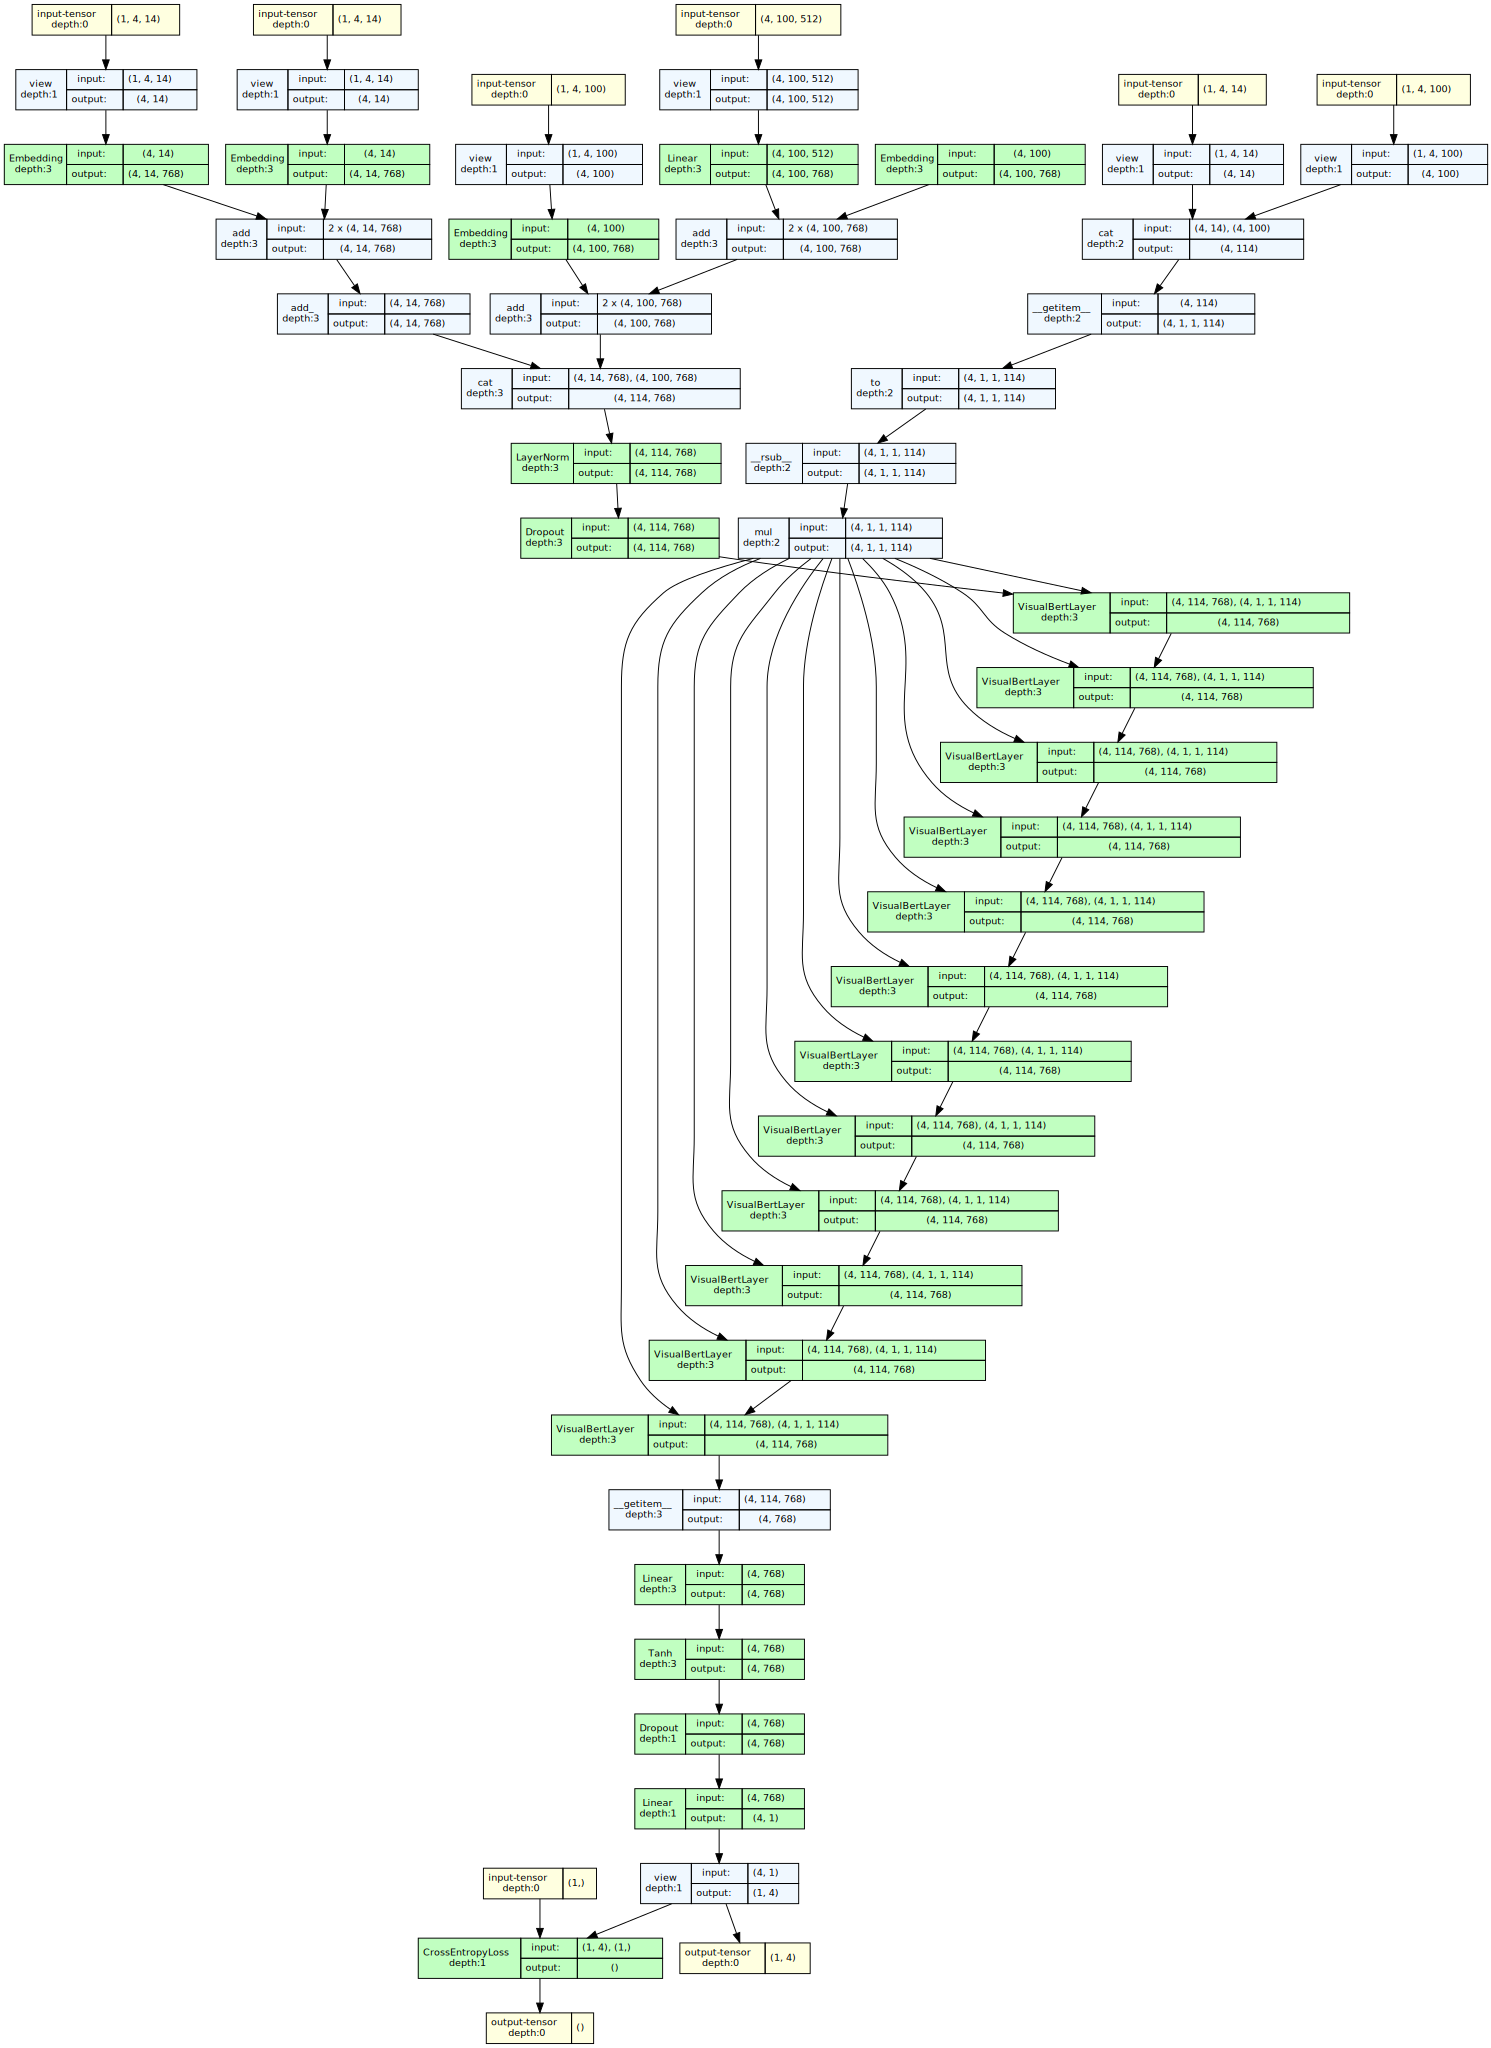

In [52]:
from torchview import draw_graph


model_graph = draw_graph(vqa_model, input_data=inputs_dict, save_graph=True)
model_graph.visual_graph


# Baseline Model Selection and Justification #

We chose to use the VisualBert for Multiple Choice because it is a model that is already pre-trained on the general downstream task that we are trying to accomplish. Moreover, the model is readily available from Huggingface, with extensive documentation on how to use de model.

Finally, compared to other multimodal models, VisualBert is smaller in size, making it more manageable and easier to train.

In [53]:
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(MAX_CHOICES)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [54]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [55]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_training_dir",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=False,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 120.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 51.06 MiB is free. Process 6804 has 14.70 GiB memory in use. Of the allocated memory 13.75 GiB is allocated by PyTorch, and 819.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Results Interpretation and Analysis

Even though me managed to start fine-tuning the model, we were not able to complete the training due to a lack of compute resources. As a team we are still strategizing on how to approach this problem and allocate the necessary resources more efficiently.

Had we completed the training, we would have evaluated the model using accuracy, and we would have compared it to inference done on the ScienceQA dataset by the baseline pre-trained VisualBERT model.


Moreover, another issue we have not yet worked out completely is how to integrate the visual feature extraction into the model training, but we are confident that we are fairly close to solving it.

# Final Model Pipeline Setup


## Data Preprocessing

- **Images:** We'll resize and potentially crop images to a size compatible with our chosen VisualBert model. Careful consideration of whether to crop and focus on specific image regions is important.
- **Image Features:** We'll select an image feature extractor that aligns well with how our VisualBert model was pre-trained. Experimentation with options like ResNet or Faster-RCNN features will help us find the best representation.
- **Text:** We'll use the same tokenizer employed during fine-tuning to ensure compatibility. This will transform the questions and answer choices into input tokens, along with any special tokens required by the model.

## Constructing Model Inputs

- **Batching:** We'll group image-question-choice examples into batches for efficient model training and inference.
- **Input Format:** We'll carefully create an input format that matches the expectations of our VisualBertForMultipleChoice model, including visual embeddings, input tokens, attention masks, and other necessary components.

## Loading the Model

- We'll load our fine-tuned VisualBertForMultipleChoice model, double-checking that it uses the correct weights and configuration.

## Optimization Setup

- **Loss:** We'll likely use cross-entropy loss as it's standard for multiple-choice tasks.
- **Optimizer:** We'll start with AdamW as a solid initial choice but keep other options in mind for potential experimentation.
- **Scheduler:** We might explore a learning rate scheduler with a warmup period to help optimize smoothly.

## Model Training

- **Training Iterations:** We'll carefully determine the number of training epochs, balancing dataset size, convergence, and validation set performance.
- **Regular Validation:** We'll consistently evaluate our model on a held-out validation set to track progress and make sure we aren't overfitting.

## Thorough Evaluation

- **Metrics:** We'll prioritize accuracy as the main metric, potentially supplementing it with others like precision and recall if we want more granular insights.
- **Test Set:** We'll use a separate test set to obtain a realistic assessment of our model's ability to generalize.




# TF Meeting

Since the meeting with Omar our TF, we changed the problem scope to be identifying the correct choice from a set of question-answer pairs. We realized that VisualBERT, while useful for handling multiple choice questions and interpreting the attached images, was not prepared to generate text answers.

Below are the goals for the last milestone:

- Documentation and notebook organization: Curren & Juan Pablo

- Model inference: Udayan

- Performance evaluation: Curren

- Creating the talk track for the video presentation: Juan Pablo